# Component Reliability

*Homework 3: start in Week 3, due in Week 5.*

<div style="background-color:#AABAB2; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>Solution</b>
    
Remember that the workshop will be based on this assignment and use some of the Python code you were asked to write!
</p>
</div>

<br>This assignment focuses on implementing the FORM analysis in Python. After a short analytic exercise on transformation of a vector or random variables to the standard normal space (ADK Problem 3.5, Part I) we will solve the reliability problem using FORM by implementing the iHL-RF algorithm (with helper code!). At the end we will compare a variety of different analyses to evaluate accuracy of the methods used and the influence of dependence (linear and non-linear).



<div style="background-color:#FFA500; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>OpenTURNS</b>
    
Some of the questions in this assignment are illustrated using Python code in two ways: 1) using the `scipy` stack and 2) using a package called [OpenTURNS](http://openturns.github.io/). The code that illustrates the answer that you should have come up with is labeled "what you should have done."
    
The package OpenTURNS will be discussed later in our course, and you will probably want to use it for your B Module assignments; the solution is provided here so that you can use it as a reference later. The package can be tricky to learn at furst, but it is very powerful. A tutorial for using it will be provided later, so you don't need to understand what is in the solution now. what you should have 
</p>
</div>

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy.stats as st
from scipy.optimize import fsolve
from scipy.integrate import quad

## Part I: Transformations

**Problem 3.5 ADK**

*Find the problem statement in the book.This exercise involves finding the transformation matrix and the Jacobian of the transformation. Because this problem is jointly normal it can be solved using Cholesky decomposition/matrix formulation, whereas in Part II we will use the Rosenblatt transformation.*

**Answer Problem 3.5**

Protocol for obtaining transformation matrix and Jacobians is presented in section 3.6.3 of ADK in depth. Its application to this problem is as follows:

We first determine the diagonal matrix of standard deviations $D_X$ as well as the correlation matrix of X $R_{XX}$:

$$ 
D_X = \begin{bmatrix} 
4 & 0 & 0  \\ 0 & \sqrt{29} & 0 \\ 0 & 0 & \sqrt{26} 
\end{bmatrix} 
$$

$$
R_{XX} = D_X^{-1}\Sigma_{XX}D_X^{-1}
= \begin{bmatrix} 
1 & 0.928 & 0.196  \\ 0.928 & 1 & 0.401 \\ 0.196 & 0.401 & 1 
\end{bmatrix} 
$$

We then obtain the Cholesky decomposition $L$ of $\Sigma_{XX}$ following the steps given in Appendix 3B at the end of Chapter 3 (ADK):

$$
L = \begin{bmatrix} 
1 & 0 & 0  \\ 0.928 & 0.373 & 0 \\ 0.196 & 0.587 & 0.786 
\end{bmatrix} 
$$

We can finally obtain the **transformation $T$** such that $U=T(X)$:

$$
\begin{split}
U = L^{-1} D_X^{-1}(X-M_X) & = \begin{bmatrix} 1 & 0 & 0  \\ 0.928 & 0.373 & 0 \\ 0.196 & 0.587 & 0.786 \end{bmatrix}^{-1} 
\begin{bmatrix} 1/4 & 0 & 0  \\ 0 & 1/\sqrt{29} & 0 \\ 0 & 0 & 1/\sqrt{26} \end{bmatrix} 
(X-M_X) \\
& = \begin{bmatrix} 0.25 & 0 & 0  \\ -0.622 & 0.498 & 0 \\ 0.402 & -0.372 & 0.249 \end{bmatrix} (X-M_X)
\end{split}
$$

The **inverse transform** $X=T^{-1}(U)$ is:

$$ X = M_X + D_X LU = M_X + \begin{bmatrix} 4 & 0 & 0  \\ 4.997 & 2.009 & 0 \\ 0.999 & 2.993 & 4.008 \end{bmatrix}U $$

Finally, we can compute the **Jacobians** of the transformation $T(X)$ ($J_{u,x}$) and the inverse transformation ($J_{x,u}$):

$$ J_{u,x} = L^{-1} D_X^{-1} = \begin{bmatrix} 0.25 & 0 & 0  \\ -0.622 & 0.498 & 0 \\ 0.402 & -0.372 & 0.249 \end{bmatrix}$$

$$ J_{x,u} = J_{u,x}^{-1} = D_X L = \begin{bmatrix} 4 & 0 & 0  \\ 4.997 & 2.009 & 0 \\ 0.999 & 2.993 & 4.008 \end{bmatrix} $$ 

*Note: results can very slightly vary (order or magnitude $10^{-3}$) depending on the method of computation and the number of significant digits kept throughout the calculations.* 

## Part II: Reliability Analysis

### Introduction

The problem considered in this assignment is defined using the following limit-state function:

$g(X_{1},X_{2})=aX_{1}^2+bX_{2}$

with $(a,b) \in \mathbb{R}^2$ and $X_1 \sim \mathcal{N}(\mu_1, \sigma_1^2), X_2 \sim \mathcal{N}(\mu_2, \sigma_2^2)$. $X_1$ and $X_2$ are correlated and $\rho=0.5$. Finally, the default values for a and b are 1 and -2, respectively. The formulation of the limit state function above allows to assess the sensitivity of the analysis' results to changes in values of a and b (subject of the next assignment). Moreover, the transformation from the original space to the standard normal space is the Rosenblatt transformation (*see 3.6.5 ADK and previous section*).

In [43]:
# Limit state function parameters:
a = 1
b = -2

# Distribution parameters X1
mu_1 = 10
sigma_1 = 2
X1 = st.norm(mu_1, sigma_1)

# Distribution parameters X2
mu_2 = 20
sigma_2 = 5
X2 = st.norm(mu_2, sigma_2)

rho = 0.5

Given the expression of the limit state function, we can determine its gradient:

$\nabla g(\vec{x_{i}}) = \begin{bmatrix}  ax_{1} & b  \end{bmatrix}$

and implement both functions in code:

In [44]:
def myLSF(x):
    ''' 
    Computes the limit state function.
    ------------
    x: (2,1) array. First coordinate corresponds to the value of X1, second to the value of X2. 
    '''
    return a*x[0,0]**2 + b*x[1,0]

def grad_myLSF(x):
    ''' 
    Computes the gradient of the limit state function. 
    
    Arguments:
    x: (2,1) array. First coordinate corresponds to the value of X1, second to the value of X2. 
    '''
    return np.array([[2*a*x[0,0], b]])

### Auxiliary Functions 

Before implementing FORM or any reliability analysis, we must define the auxiliary functions needed in the iHL-RF algorithm.  

<div style="background-color:#FFA500; vertical-align: middle; padding:3px 20px;">
<p>
<b>Transformations</b>

Similar to the iHL-RF algorithm, we outline functions to help you make the transformation to the standard normal space. This is necessary for a variety of reasons, in particular:
- the integration of the linearized limit-state can be done much more easily in the standard normal space
- the design point and importance measures in the $U$ space can give valuable insight
- the algorithm is more stable
- numerical issues are less common (machine precision)
- there are probably even more...

</p>
</div>

### Question 1a: Analytic $J$

Determine the analytic expression of the Jacobian in the 2D case.

**Answer:**

In the 2D case, the coefficients of the Rosenblatt transformation's Jacobian are defined in equation (3.65) in ADK. By direct application in the 2D case, the Jacobian $J_{u,x}$ is:

$J_{u,x} = \begin{bmatrix} \frac{f_{1}(x_{1})}{\phi(u_{1})} & 0  \\ \frac{1}{\phi(u_{2})}\frac{\partial F_{2|1}(x_{2}|x_{1})}{\partial x_{1}} & \frac{f_{2|1}(x_{2}|x_{1})}{\phi (u_{2})} \end{bmatrix}$ 

In a concern of readability, the function will be implemented using auxiliary functions. The structure is as follows:

$J_{u,x} = \begin{bmatrix} \frac{f_{1}(x)}{\phi(u_{1})} & 0  \\ \frac{f_{2}(x)}{\phi(u_{2})} & \frac{f_{3}(x)}{\phi (u_{2})} \end{bmatrix}$ 

with the $f_{i}$ being the auxiliary functions. 

### Question 1b: Python $J$

In the following group of cells, there are several pieces of code to fill in:
* in `jacobian` enter the missing elements of the matrix
* in `cond_param` add the parameters of the conditional distribution
* in `f1`, `f2` and `f3` add the missing pdf to the `return` line (note that one or more of these functions will need a conditional pdf, so you should define the parameters inside the function using `cond_param`.
* fill in each element of the transformation vectors `X2U` and `U2X` (be careful in choosing which one needs the conditional parameters)

Determine the literal expression of the Jacobian in the 2D case and define the related Python function(s).

In [45]:
def jacobian(f1, f2, f3, x, u):
    ''' Computes the Jacobian of the transformation from the original space to the standard 
    normal space. 
    
    Arguments:
    f1, f2, f3: Python functions. See structure above.
    x: (2,1) array. Point in the original space at which the Jacobian is evaluated.
    u: (2,1) array. Point in the standard normal space at which the Jacobian is evaluated.
    '''
    J = np.zeros((2,2))
    J[0,0] = f1(x)/st.norm.pdf(u[0,0])
    J[1,0] = f2(x)/st.norm.pdf(u[1,0])
    J[1,1] = f3(x)/st.norm.pdf(u[1,0])
    return J

In the case of a bivariate normal distribution, determining conditional distributions is easy. More precisely, and as presented at the end of ADK section 3.2, $(Y|X=x) \sim \mathcal{N}(\mu_{X_2|X_1=x_1}, \sigma_{X_2|X_1=x_1}^2)$ with:

$$ \mu_{X_2|X_1=x_1} = \mu_{X_2} + \rho \sigma_{X_2} (\frac{x_1 - \mu_{X_1}}{\sigma_{X_1}}) \tag{3.14} $$  

$$ \sigma_{X_2|X_1=x_1} = \sigma_{X_2}\sqrt{1-\rho^2} \tag{3.15} $$  

**Note:** the functions above only apply for the bivariate normal case.

In [46]:
def cond_param(X1, X2, x1):
    ''' Computes the distribution parameters of X2|X1=x1. 
    
    Arguments:
    X1, X2: random variables. 
    x1: float. 
    '''   
    sigma = X2.std()*np.sqrt(1-rho**2)
    mu = X2.mean() + rho*X2.std()*(x1-X1.mean())/X1.std()
    return mu, sigma

We define the functions $f_{i}$ necessary to compute the Jacobian:

In [47]:
def f1(x):
    '''
    Computes the probability density of X1=x1.
    
    Arguments:
    x: (2,1) array. First coordinate corresponds to value of X1, second coordinate the one of X2. 
    '''
    return st.norm.pdf(x[0,0], loc=mu_1, scale=sigma_1)

def f2(x, X1=X1, X2=X2):
    '''
    Computes the partial derivative of F2_1 by x1.
    
    Arguments:
    x: (2,1) array. First coordinate corresponds to value of X1, second coordinate the one of X2.
    X1, X2: random variables.  
    '''
    mu, sigma = cond_param(X1, X2, x[0,0])
    return -rho*sigma_2/(sigma_1*sigma)*st.norm.pdf((x[1,0]-mu)/sigma)

def f3(x, X1=X1, X2=X2):
    '''
    Computes the probability density of X2=x2 given X1=x1 .
    
    Arguments:
    x: (2,1) array. First coordinate corresponds to value of X1, second coordinate the one of X2. 
    X1, X2: random variables.
    '''
    mu, sigma = cond_param(X1, X2, x[0,0])
    return st.norm.pdf(x[1,0], loc=mu, scale=sigma)

Finally, we define functions that allow to transform a point in the original space into the standard normal space and conversely. 

In [48]:
def X2U(x):
    ''' 
    Computes the projection of a point from the original space to the standard normal space.
    
    Arguments:
    x: (2,1) array. Point in the original space (X).
    '''
    mu, sigma = cond_param(X1, X2, x[0,0])
    u = np.zeros((2,1))
    u[0,0] = st.norm.ppf(st.norm.cdf(x[0,0], loc=mu_1, scale=sigma_1))
    u[1,0] = st.norm.ppf(st.norm.cdf(x[1,0], loc=mu, scale=sigma))
    return u

def U2X(u):
    ''' 
    Computes the projection of a point from the standard normal space to the original space.

    Arguments: 
    u: (2,1) array. Point in the standard normal space (U).
    '''
    x = np.zeros((2,1))
    x[0,0] = st.norm.ppf(st.norm.cdf(u[0,0]), loc=mu_1, scale=sigma_1)
    mu, sigma = cond_param(X1, X2, x[0,0])
    x[1,0] = st.norm.ppf(st.norm.cdf(u[1,0]), loc=mu, scale=sigma)
    return x

## iHL-RF Algorithm

### Question 2

Complete the implementation of the iHL-RF algorithm. There are only three partial lines of code you need to fill in within the FORM algorithm: the alpha vector, reliability index and failure probability.

<div style="background-color:#FFA500; vertical-align: middle; padding:3px 20px;">
<p>
    
<b>iHL-RF Algorithm and Expected Knowledge</b>

Although Chapter 6 introduces the FORM method in a general sense, Robert didn't realize until after assigning the reading that the iHL-RF algorithm is presented in Chapter 4. Specifically, it is outlined in Figure 5.2 (near pg 116/594 in the digital textbook). This is, in a nutshell, a gradient-based search method (an optimization problem). Because we outline the method in the code below, you should be able to finish the exercise with a few quick references to Chapter 5 (as well as the transformation sections in Chapter 3). You are not expected to memorize this entire algorithm, but instead recognize what it is doing: finding the point on the limit-state surface that maximizes probability density!
</p>
</div>

**Answer:**

The different steps - as presented in Figure 5.2, ADK - are illustrated in the code using comments.

In [49]:
def merit(u, G, c):
    ''' 
    Merit function.
    
    Arguments:
    u: 2D-array. Iteration point in the standard normal space.
    G: float. Evaluation of the limit state function at the current iteration point.
    c: float. Current value of c. 
    '''
    m = 0.5*(np.linalg.norm(u)**2) + c*G
    return m

In [50]:
def FORM(g, grad_g, epsilon_1=10e-3, epsilon_2=10e-3):
    ''' 
    FORM analysis. 

    Arguments:
    g: func. Limit state function.
    grad_g: func. Gradient of the limit state function.
    epsilon_1, epsilon_2: float. Tolerance of the two convergence criteria of iHL-RF.
    '''

    # Initialize
    # Iteration count
    i=0
    # x and u are stored in lists to keep information on the convergence of the algorithm
    x = []       
    u = []
    # Initiate first iteration point with mean values
    x.append(np.array([mu_1, mu_2]).reshape(2,1))
    u.append(X2U(x[-1]))
    G_0 = g(x[-1])

    while (i==0 or 
           (abs(G/G_0) > epsilon_1) or 
           (np.linalg.norm((u[-1] - np.matmul(alpha, u[-1])
                            *np.transpose(alpha))) > epsilon_2)):
        # ^ Verify convergence criteria 
        
        # Compute
        G = g(x[-1])
        grad_X = grad_g(x[-1])
        Jux = jacobian(f1, f2, f3, x[-1], u[-1])
        # Calculate inverse Jacobian with NumPy rather than analytically
        # (reduces hand calculations)
        Jxu = np.linalg.inv(Jux)
        grad_U = np.matmul(grad_X, Jxu)
        
        # FILL IN SOMETHING IN THIS LINE:
        alpha = -grad_U/np.linalg.norm(grad_U)
        
        # Arbitrary initial value
        c = 10   
        # Condition on c defined in iHL-RF
        while c <= np.linalg.norm(u[-1])/np.linalg.norm(grad_U):
            c+=1
        m = merit(u[-1], G, c)                            

        # Determine search direction
        p = G/np.linalg.norm(grad_U) + np.matmul(alpha, u[-1])
        d = p*np.transpose(alpha) - u[-1]

        # Determine step size
        # test_lambda could also be initiated True, but it was considered 
        # more intuitive to set the condition as False before having to validate it 
        test_lamda = False
        k=0
        while not test_lamda:
            # Rather than the Armijo rule, it's common practice to divide 
            # lambda by 2 at each iteration
            lamda = 0.5**k
            u_test = u[-1] + lamda*d
            x_test = U2X(u_test)
            G_test = g(x_test)
            # Verify condition on lambda for correct step size
            test_lamda = m > merit(u_test, G_test, c)
            k+=1
        
        # Determine new iteration point
        u.append(u_test)
        x.append(x_test)
        i+=1
                
    # FILL IN SOMETHING IN THIS LINE:
    beta = np.matmul(alpha, u[-1])[0,0] # Compute reliability index at design point           
    # FILL IN SOMETHING IN THIS LINE:
    pf = st.norm.cdf(-beta)                    
    
    # Finally, return a bunch of readible and relevant variables. The gradient and alpha,
    # for instance, prove useful when investigating the sensitivity of the algorithm's 
    # output in regard to limit state function and distribution parameters. 
    sol = {"Point (standard normal space)":u[-1],
           "Design point":x[-1],
           "Gradient of U":grad_U,
           "Failure probability":"{:.4g}".format(pf),
           "alpha":alpha,
           "beta":"{:.4g}".format(beta),
           "Iterations":i}
    
    # Return u and x to access all iterations and eventually plot 
    # a figure similar to Figure 5.3 ADK
    return sol, u, x              

We then run the algorithm and display the variables of interest:

<div style="background-color:#FFA500; vertical-align: middle; padding:3px 20px;">
<p>
Note: sometimes the algorithm in the next cell gets "stuck" due to some numerical issues, if this happens restart your kernel.
</p>
</div>

In [51]:
results = FORM(myLSF, grad_myLSF)
print("The design point in the original space obtained by FORM is: ",
      results[0]["Design point"])
print("The design point in the standard normal space obtained by FORM is: ",
      results[0]["Point (standard normal space)"])
print("The system's failure probability is: ", results[0]["Failure probability"])
print("The results above are reached in {} iterations".format(results[0]["Iterations"]))

The design point in the original space obtained by FORM is:  [[ 6.14851338]
 [18.9013209 ]]
The design point in the standard normal space obtained by FORM is:  [[-1.92574331]
 [ 0.85809935]]
The system's failure probability is:  0.0175
The results above are reached in 3 iterations


### OpenTURNS Implemention

Run a FORM analysis using OpenTURNS. You don't need to do anything in this section, it provided for you for future reference in using OpenTURNS, and also to check that you completed the implementation of FORM correctly.


In [52]:
import openturns as ot
import openturns.viewer as viewer
ot.Log.Show(ot.Log.NONE)

In order to use Python functions in OpenTURNS, the limit state function defined as ```myLSF``` must be vectorized : both its arguments and returns are vectors.

In [53]:
def myLSF_vect(x):
    ''' 
    Vectorized limit state function.
    ------------
    x: (2,1) array. First coordinate corresponds to the value of X1, second to the value of X2. 
    '''
    return [a*x[0]**2 + b*x[1]]

We then setup the analysis using the 'normal' implementation. Steps are commented in-place. 

In [54]:
# Definition of random variables
x1 = ot.Normal(mu_1, sigma_1)          # X1 already assigned to normal RV defined with scipy.stats
x2 = ot.Normal(mu_2, sigma_2)          # Idem for X2

# Definition of the dependence structure: here, bivariate normal with correlation coefficient rho.
R = ot.CorrelationMatrix(2)   
R[0,1] = rho
R[1,0] = rho
bivar_copula = ot.NormalCopula(R)

inputDistribution = ot.ComposedDistribution((x1,x2), bivar_copula)
inputDistribution.setDescription(["x1", "x2"])
inputRandomVector = ot.RandomVector(inputDistribution)

myfunction = ot.PythonFunction(2, 1, myLSF_vect)

# Vector obtained by applying limit state function to X1 and X2
outputvector = ot.CompositeRandomVector(myfunction, inputRandomVector)

# Define failure event: here when the limit state function takes negative values
failureevent = ot.ThresholdEvent(outputvector, ot.Less(), 0)
failureevent.setName('LSF inferior to 0')

In [55]:
optimAlgo = ot.Cobyla()
optimAlgo.setMaximumEvaluationNumber(1000)
optimAlgo.setMaximumAbsoluteError(1.0e-10)
optimAlgo.setMaximumRelativeError(1.0e-10)
optimAlgo.setMaximumResidualError(1.0e-10)
optimAlgo.setMaximumConstraintError(1.0e-10)

algo = ot.FORM(optimAlgo, failureevent, inputDistribution.getMean())
algo.run()
result = algo.getResult()
x_star = result.getPhysicalSpaceDesignPoint()
u_star = result.getStandardSpaceDesignPoint()
pf = result.getEventProbability()
print('FORM result, pf = {:.4f}'.format(pf))
print('FORM result, beta = {:.3f}\n'.format(result.getHasoferReliabilityIndex()))
print(u_star)

FORM result, pf = 0.0175
FORM result, beta = 2.108

[-1.92808,0.852995]


In [56]:
results = FORM(myLSF, grad_myLSF)
print("The design point in the original space ",
      "obtained by FORM with OpenTURNS is: ", x_star)
print("The design point in the standard normal space ",
      "obtained by FORM with OpenTURNS is: ", u_star)
print("The system's failure probability obtained by FORM ",
      "with OpenTURNS is: ", "{:.4g}".format(pf))

The design point in the original space  obtained by FORM with OpenTURNS is:  [6.14384,18.8734]
The design point in the standard normal space  obtained by FORM with OpenTURNS is:  [-1.92808,0.852995]
The system's failure probability obtained by FORM  with OpenTURNS is:  0.0175


Check if failure probability computed with OpenTURNS is equal to the one given by the iHL-RF algorithm.

In [57]:
assert abs(1 - float(results[0]["Failure probability"])/pf) < 0.01, "Incorrect lambda value"

### OpenTURNS MCS

Using OpenTURNS and the setup defined in the cells above, run a Monte Carlo Simulation and compare the results with the ones obtained with FORM.

In [58]:
montecarlosize = 10000
outputSample = outputvector.getSample(montecarlosize)

number_failures = sum(i < 0 for i in np.array(outputSample))[0]      # Count the failures, i.e the samples for which Z<0
pf_mc = number_failures/montecarlosize

In [59]:
print("The failure probability computed with FORM (iHL-RF) is: ",
      results[0]["Failure probability"])
print("The failure probability computed with FORM (OpenTURNS) is: ",
      "{:.4g}".format(pf))
print("The failure probability computed with MCS (OpenTURNS) is: ",
      "{:.4g}".format(pf_mc))

The failure probability computed with FORM (iHL-RF) is:  0.0175
The failure probability computed with FORM (OpenTURNS) is:  0.0175
The failure probability computed with MCS (OpenTURNS) is:  0.0172


### Question 3: Compare

Compare the answers from our iHL-RL implementation with that of OpenTURNS (which uses a different optimization strategy) and MCS. Are there differences? Explain why.

**Answer:**

The two FORM calculations are identical, but the failure probability form MCS is lower than FORM. The difference is due to FORM being a linear approximation. Since the probability is lower, the true failure surface must be further from the center of the joint PDF (i.e., further from the origin in the standard normal space); in other words, it probably is curving away from the design point (we will see this is indeed the case later). FORM thus overestimates the failure probability, but not by much.

### Question 4: Importance Measures

The code below computes the importance factors manually using the design point obtained via FORM (OpenTURNS). The protocol is presented in ADK, section 6.5. Interpret the importance measures: are the random variables loads or resistances? Which one is most important? How does this relate to the functional and stochastic influence of the random variable on the calculated failure probability?

In [60]:
x_s = np.array(x_star).reshape(-1,1)
u_s = np.array(u_star).reshape(-1,1)

In [61]:
Jux = jacobian(f1, f2, f3, x_s, u_s) 
Jxu = np.linalg.inv(Jux)

In the following cells, ``M_app`` is equivalent to $\widetilde{M}$, likewise for $\widetilde{D}$ and $\widetilde{S}$.

In [62]:
M_app = x_s - np.matmul(Jxu, u_s)
S_app = np.matmul(Jxu, np.transpose(Jxu))
D_app = np.diag(np.sqrt(np.diag(S_app)))

In [63]:
grad_U = np.matmul(grad_myLSF(x_s), Jxu)
alpha_man = -grad_U/np.linalg.norm(grad_U)

In [64]:
alpha_ot = result.getImportanceFactors()
print("The alpha value as defined in OpenTURNS is: ", alpha_ot)
print("The alpha value as defined in ADK is: ", alpha_man)

The alpha value as defined in OpenTURNS is:  [x1 : 0.986527, x2 : 0.0134734]
The alpha value as defined in ADK is:  [[-0.91450206  0.40458124]]


<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<p>
Note: the methods give completely diverging results!
</p>
</div>

This has to do with the definition of importance factors in the ADK textbook and in OpenTURNS' FORM documentation: see [OpenTURNS documentation](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.FORMResult.html#openturns.FORMResult.getHasoferReliabilityIndexSensitivity). Although it doesn't take long to work out what the difference is analytically, you don't need to look into this now, but it is very important to remember: always check how other software is making "familiar" computations: sometimes things are not as they seem!

**Answer:**

Going by the iHL-RF results, we can easily see that $X_1$ has the biggest influence, since it has a higher magnitude, and it is a load, as it is negative. The importance measure includes both functional and stochastic response of the random variables: we can see this because it is based on the design point in the $U$ space, which is an inner product of the gradient (sensitivity of the limit-state function to changes in the variable value) and Jacobian of the transformation, which incorporates the variance of the random variable through the ratio of the PDF's in the Jacobian terms.

### Question 5: AND and OR

We have one more set of auxiliary functions to complete: fill in the functions below and then evaluate them for the design point from FORM, `x_star` (you will need to use the bivariate and marginals random variables, both of which are objects evaluated with the method `computeCDF()`).

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<p>
These functions require the bivariate PDF as input, which is most easily done using OpenTURNS.
    
To specify the bivariate PDF, use the `ComposedDistribution` object defined above, which are given variable names that start with `inputDistribution` and can be evaluated with a list as input using the following method: `inputDistribution.computePDF([X_1, X_2])`
</p>
</div>

In [65]:
def p_OR(dis, x):
    ''' Computes the probability P(X1>x1 OR X1>x2). 
    
    Parameters:
    dis : OT ComposedDistribution
    x: 1D vector. First and second coordinates contain values of x1 and x2, respectively. 
    '''
    return 1 - dis.computeCDF(x)

def p_AND(dis, x):
    ''' Computes the probability P(X1>x1 AND X1>x2). 
    
    Parameters:
    dis : OT ComposedDistribution
    x: 1D vector. First and second coordinates contain values of x1 and x2, respectively. 
    '''
    X1 = dis.getMarginal(0)
    X2 = dis.getMarginal(1)
    p = X1.computeCDF(x[0]) + X2.computeCDF(x[1]) - dis.computeCDF(x)
    return p

In [66]:
pf_and = p_AND(inputDistribution, x_star)
pf_or = p_OR(inputDistribution, x_star)

We will evaluate the results later, once all the analyses are completed.

## Dependence Models

Next we will consider how dependence influences the results of our analyses by assuming the random variables are: independent (Case 2) and non-linearly dependent using a Clayton Copula (Case 3). The previous analysis will be referred to as Case 1. We will continue to use the same limit-state function and random variables as above. We will also compare the failure probability calculated using the limit-state function to the AND and OR failure definitions.

### Case 2: independent bivariate normal

The first additional case we investigate is the one in which $X_1$ and $X_2$ still follow normal distributions (with the same distribution paramaters) but are now independent, i.e $\rho=0$. We rapidly perform the same analyses as previously to compare the failure probabilities obtained.

We first setup a FORM analysis:

In [67]:
inputDistribution_2 = ot.ComposedDistribution((x1,x2))
inputDistribution_2.setDescription(["X1", "X2"])
inputRandomVector_2 = ot.RandomVector(inputDistribution_2)

outputvector_2 = ot.CompositeRandomVector(myfunction, inputRandomVector_2)

failureevent = ot.ThresholdEvent(outputvector_2, ot.Less(), 0)
failureevent.setName('LSF inferior to 0')

algo = ot.FORM(optimAlgo, failureevent, inputDistribution_2.getMean())
algo.run()
result_2 = algo.getResult()
x_star_2 = result_2.getPhysicalSpaceDesignPoint()
u_star_2 = result_2.getStandardSpaceDesignPoint()
pf_2 = result_2.getEventProbability()
print('FORM result, pf = {:.5f}'.format(result_2.getEventProbability()))
print('FORM result, beta = {:.3f}\n'.format(result_2.getHasoferReliabilityIndex()))
print(u_star_2)

FORM result, pf = 0.04298
FORM result, beta = 1.717

[-1.61098,0.59419]


Then, similarly to Question 4, a Monte Carlo analysis is conducted:

In [68]:
outputSample = outputvector_2.getSample(montecarlosize)

number_failures_2 = sum(i < 0 for i in np.array(outputSample))[0]
pf_mc_2 = number_failures_2/montecarlosize

Finally, we compute the AND and OR probabilities:

In [69]:
pf_and_2 = p_AND(inputDistribution_2, x_star_2)
pf_or_2 = p_OR(inputDistribution_2, x_star_2)

### Case 3: Clayton copula

In this second case, $X_1$ and $X_2$ follow once again the Normal distributions, but dependence between these two marginal distributions is modeled with a Clayton copula. You do not need to know more for this course than the fact that a copula is a way to describe the join PDF (or CDF) of two random variables; while a bivariate Normal distribution is one type of copula, there are many more copulas that include a variety of non-linear dependence structures.

Once the copula is defined using a parameter of $\theta=2.5$ (a value that models strong positive correlation similar to Case 1, except non-linear), FORM and Monte Carlo analyses are performed:

In [70]:
theta = 2.5 # positive dependence

# Define Clayton copula with parameter theta
clayton_copula = ot.ClaytonCopula(2.5)

inputDistribution_3 = ot.ComposedDistribution((x1,x2), clayton_copula)
inputDistribution_3.setDescription(["X1", "X2"])

inputRandomVector_3 = ot.RandomVector(inputDistribution_3)

outputvector_3 = ot.CompositeRandomVector(myfunction, inputRandomVector_3)

failureevent = ot.ThresholdEvent(outputvector_3, ot.Less(), 0)
failureevent.setName('LSF inferior to 0')

# Idem

algo = ot.FORM(optimAlgo, failureevent, inputDistribution_3.getMean())
algo.run()
result_3 = algo.getResult()
x_star_3 = result_3.getPhysicalSpaceDesignPoint()
u_star_3 = result_3.getStandardSpaceDesignPoint()
pf_3 = result_3.getEventProbability()
print('FORM result, pf = {:.5f}'.format(result_3.getEventProbability()))
print('FORM result, beta = {:.3f}\n'.format(result_3.getHasoferReliabilityIndex()))
print(u_star_3)

FORM result, pf = 0.00033
FORM result, beta = 3.404

[-1.37549,3.11324]


In [71]:
outputSample = outputvector_3.getSample(montecarlosize)

number_failures_3 = sum(i < 0 for i in np.array(outputSample))[0]
pf_mc_3 = number_failures_3/montecarlosize

Finally, we compute the AND and OR probabilities:

In [72]:
pf_and_3 = p_AND(inputDistribution_3, x_star_3)
pf_or_3 = p_OR(inputDistribution_3, x_star_3)

### Comparison of Results

Finally, the results computed using different methods (FORM, MCS) and different dependences structures are presented in the table below:

In [73]:
comp = np.array([[pf, pf_2, pf_3],
             [pf_mc, pf_mc_2, pf_mc_3],
             [pf_and, pf_and_2, pf_and_3],
             [pf_or, pf_or_2, pf_or_3]])
comp = np.around(comp, decimals=4)
headers = ["Case 1", "Case 2", "Case 3"] 
methods = ["FORM", "Monte Carlo", "AND probability", "OR probability"]

tab = pd.DataFrame(comp, columns=headers, index=methods)
tab.head()

Case 1  Case 2  Case 3
FORM             0.0175  0.0430  0.0003
Monte Carlo      0.0172  0.0382  0.0004
AND probability  0.4148  0.7386  0.8953
OR probability   0.9770  0.9612  0.9155

### Question 6: Interpretation

For all three cases create a plot that illustrates the probability density contours, limit-state function and design point. Then use the figures and computations to interpret the result of the reliability analysis by answering the following questions:  
1. Why are the probabilities different for each method? (i.e., compare values in same row)
1. Why are the probabilities different for each case? (i.e., compare values in same column)
1. Explain why the MCS results are always smaller than FORM in this case.
1. How does the design point change for each case? Why?
1. Imagine the reliability analysis and limit-state function is used to design a structure by determining the *average resistance* (as opposed to influencing the load). Assume Cases 1, 2 and 3 each are legitimate models of the dependence between the random variables. Compare and contrast the different models and determine if the choice of models could have a big impact on your design.
1. Do the AND or OR failure models represent the design case for this LSF well? Why or why not?
1. Consider Case 3: describe the contours and what this implies for the relationship betweeh $X_1$ and $X_2$ in plain language. Can you think of a real-life scenario where this behaviour might be observed?

**Answer:**

1. Different dependence models, resulting in different PDF's and probabilities in failure region are different. This can be seen visually through the contours.
1. Methods are different: FORM is a linear approximation; AND and OR are very limited in the failure regions that they define (different parts of a quadrant).
1. The limit-state function is clearly concave away from the median of the joint distribution (the top of the "mound"), which means the linear approximation overestimates the true failure probability.
1. The design point is located on the limit-state surface point with the highest probability density. The contours change, along with their relationshipt to the limit-state. Relative to Case 1, Case 2 removed dependence, and Case 3 introduces linear dependence.
1. From the previous question it is clear that the bivariate PDF has a big impact on the design point in this case (e.g., see the difference in the design points). But it doesn't seem to matter much if you can control $X_1$ in your design and make it large---this has a bigger effect that the variation in contours for the 3 Cases. The mean of resistance governs the peak of the density "mound." This is also apparent in the alpha value for $X_1$.
1. No, they don't match the failure region at all! The AND and OR cases only evaluate one set of key design conditions (at the design point). By imagining where the respective integration areas are, we can see that a significant portion of the failure region is missed (e.g., nearly all of the failure region is missed for the AND case). However, the calculated probability is still higher because the AND case also integrates across many non-failure random variable combinations. Clearly this is a bad model for the mathematical definition of failure.
1. There is a strong positive correlation: for both random variables, high values occur together (as well as low). However, there is a difference in that the correlation seems to reduce as the values (jointly) become higher. This is non-linear dependence. It could be described as strong lower-tail dependence, due to the narrowness of the contours for low values. This could occur in real life perhaps in the discharge of 2 small rivers with similarly sized watersheds located closely together: when the weather is dry, the discharge is small

<div style="background-color:#F9E076; vertical-align: middle; padding:3px 20px;">
<p>
To make these plots, use should use the function `plot_contour` from HW1, which needs to be adapted to take into account: the different bivariate proibability distribution, the new limit-state function, remove the MCS samples, chack that the proper failure domain is shaded, add the design point.
    
Hint: remember to use a OpenTURNS `ComposedDistribution` object for the bivariate PDF.
</p>
</div>

In [74]:
def plot_contour(bivar, x_star, xlim= None, ylim=None, nb_points=200):
    """ 
    Contour plot in the bivariate plane (X,Y).
    ---------------------
    bivar: bivariate distribution.
    xlim, ylim: tuple, list. Intervals of values of x and y 
        displayed in the figure (default: None).
    nb_points: int. Size of the grid (default: 200).

    returns: matplotlib.pyplot Figure and Axis objects. 
    """
    
    f, ax = plt.subplots(1)

    if xlim is None:
         xlim = [X1.mean() - 3*X1.std(), X1.mean() + 3*X1.std()]
    if ylim is None:
         ylim = [X2.mean() - 3*X2.std(), X2.mean() + 3*X2.std()]

    x = np.linspace(xlim[0], xlim[1], nb_points)
    y = np.linspace(ylim[0], ylim[1], nb_points)
    X,Y = np.meshgrid(x,y)
    pdf = np.zeros(X.shape)
    for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                if X[i,j]>0 and Y[i,j]>0:
                    pdf[i,j] = bivar.computePDF([X[i,j], Y[i,j]])

    limit_state = x**2/2
    
    ax.contour(X, Y, pdf, levels=8, cmap=cm.Blues)
    ax.plot(x, limit_state, label='LSF', color='k')
    ax.fill_between(x, limit_state, ylim[1], label='Failure domain', color='grey')   
    ax.plot(x_star[0], x_star[1], 'ro', label='Design point')  # plot LSF
    
    ax.set_aspect("equal")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel(r"$X_1$", fontsize=14)
    ax.set_ylabel(r"$X_2$", fontsize=14)
    ax.legend()
    return f, ax 

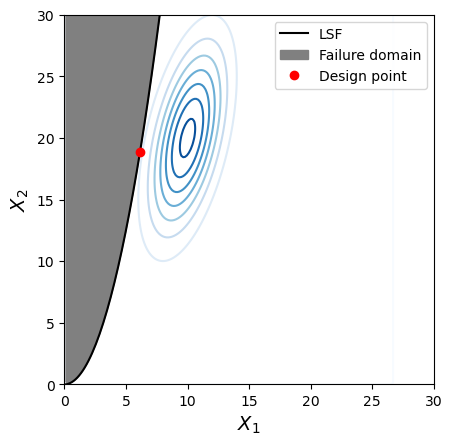

In [75]:
plot_limits = [0, 30]
f, ax = plot_contour(inputDistribution, x_star, xlim=plot_limits, ylim=plot_limits)

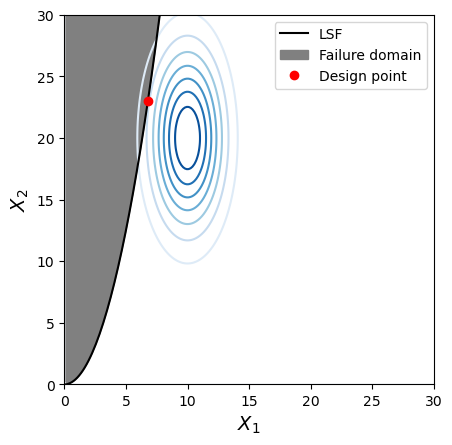

In [76]:
f, ax = plot_contour(inputDistribution_2, x_star_2, xlim=plot_limits, ylim=plot_limits)

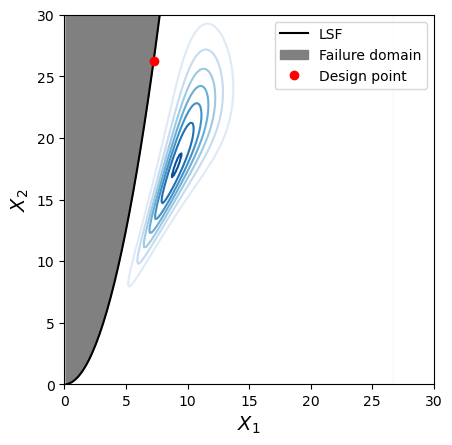

In [77]:
f, ax = plot_contour(inputDistribution_3, x_star_3, xlim=plot_limits, ylim=plot_limits)